# COMP541 Visualization Lab
* In this Lab you will implement some methods and experiment with several visualization techniques.
* Please read all the instructions and comments carefully.
* **IMPORTANT: NEXT STEP MAY TAKE A LITTLE BIT LONGER. PLEASE WAIT UNTILL ALL YOUR PACKAGES are installed.**

In [0]:
# Installation cell
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add Plots; add PyPlot; add IJulia; add Knet;"'
julia -e 'using Pkg; pkg"build Knet;"'

--2020-06-03 19:12:17--  https://julialang-s3.julialang.org/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz
Resolving julialang-s3.julialang.org (julialang-s3.julialang.org)... 151.101.2.49, 151.101.66.49, 151.101.130.49, ...
Connecting to julialang-s3.julialang.org (julialang-s3.julialang.org)|151.101.2.49|:443... connected.
HTTP request sent, awaiting response... 302 gce internal redirect trigger
Location: https://storage.googleapis.com/julialang2/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz [following]
--2020-06-03 19:12:18--  https://storage.googleapis.com/julialang2/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 2607:f8b0:400c:c13::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95929584 (91M) [application/x-gzip]
Saving to: ‘/tmp/julia.tar.gz’

/tmp/julia.tar.gz   100%[===================

In [1]:
# You may comment out this cell after installing all the necessary packages
using Pkg; installed = Pkg.installed()
for p in ("Knet","KnetLayers","Images","ImageMagick","Plots","Plotly","PlotlyJS","ORCA", "BSON")
    haskey(installed,p) || Pkg.add(p)
end
# PLEASE WAIT TO FINISH PACKAGE INSTALLATION

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
 Installed KnetLayers ─ v0.2.0
  Updating `~/.julia/environments/v1.3/Project.toml`
  [e09e3f5a] + KnetLayers v0.2.0
  Updating `~/.julia/environments/v1.3/Manifest.toml`
  [e09e3f5a] + KnetLayers v0.2.0
 Resolving package versions...
 Installed UnPack ──────────────────── v1.0.1
 Installed IntelOpenMP_jll ─────────── v2018.0.3+0
 Installed PaddedViews ─────────────── v0.5.5
 Installed ImageTransformations ────── v0.8.4
 Installed IterTools ───────────────── v1.3.0
 Installed RangeArrays ─────────────── v0.3.2
 Installed Images ──────────────────── v0.22.2
 Installed ImageShow ───────────────── v0.2.3
 Installed ImageCore ───────────────── v0.8.14
 Installed Interpolations ──────────── v0.12.10
 Installed EllipsisNotation ────────── v0.4.0
 Installed Ratios ──────────────────── v0.4.0
 Installed ImageDistances ──────────── v0.2.7
 Inst

In [2]:
# A bit of setup as usual
using Knet, KnetLayers, Images, Plots, Statistics

_usegpu = gpu()>=0
_atype = ifelse(_usegpu, KnetArray{Float32}, Array{Float32})

const imgdata = [("https://github.com/BVLC/caffe/raw/master/examples/images/cat.jpg", "cat.jpg", 284),
                 ("http://farm1.static.flickr.com/64/168461914_afe4852372.jpg", "elephant.jpg",387),
                 ("http://www.treetopics.com/quercus_macrocarpa/buroak_2919.jpg","buroak_2919.jpg",704),
                 # ("http://www.burningwell.org/gallery2/d/9655-2/Hammer+in+Sunlight.JPG","Hammer+in+Sunlight.JPG",824),
                 ("https://i.ibb.co/J2jdYjH/15-1.jpg","dog.jpg",187)
                ]
# plotlyjs()

include(KnetLayers.dir("examples","resnet.jl"))
if !isfile(KnetLayers.dir("examples","resnet.bson"))
    download("https://github.com/FluxML/Metalhead.jl/releases/download/v0.1.1/resnet.bson",KnetLayers.dir("examples","resnet.bson"))
end

┌ Info: Precompiling Knet [1902f260-5fb4-5aff-8c31-6271790ab950]
└ @ Base loading.jl:1273
┌ Info: Precompiling KnetLayers [e09e3f5a-3c2e-516c-a806-60ae64389a85]
└ @ Base loading.jl:1273
Expr(:call, :ccall, Expr(:tuple, "cudaGetErrorString", "/usr/local/cuda-10.1/lib64/libcudart.so"), :Cstring, Expr(:tuple, :UInt32), 0x00000064)
  ** incremental compilation may be fatally broken for this module **

Expr(:call, :ccall, Expr(:tuple, "nvmlErrorString", "/usr/lib/x86_64-linux-gnu/libnvidia-ml.so"), :Cstring, Expr(:tuple, :UInt32), 0x00000009)
  ** incremental compilation may be fatally broken for this module **

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1273
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273
┌ Info: Precompiling BSON [fbb218c0-5317-5bc6-957e-2ee96dd4b1f0]
└ @ Base loading.jl:1273


"/root/.julia/packages/KnetLayers/zfhNR/examples/resnet.bson"

In [0]:
# Construct our model based on ResNet50
model = trained(ResNet50)

# Returns class probabilities for the input `x`
resnet_forward(x...) = model(x...)

# Returns class scores for the input `x` (same model without the softmax)
resnet_unnormalized(x...) = model.layers[1:21](x...);

## Implement Image Processing Procedures

In [4]:
# Takes a url `url` or file name `localpath` and returns an `Array{RGB}`
# It does not resize or modify the original image.
function loadimage(url, localpath)
    global _imgcache
    if !isfile(localpath)
        @info "Downloading $url to $localpath"
        download(url, localpath)
    end
    return load(localpath)
end

# Resize the input image `img` and then take 224-by-224 pixels at the center of it.
function resizecropimage(img::AbstractMatrix{<:AbstractRGB})
    img = resize_smallest_dimension(img, 256)
    center_crop(img, 224)
end

# Takes cropped image `img` and then prepares it for pretrained CNN
function preprocesscroppedimage(img::AbstractMatrix{<:AbstractRGB})
    z = (channelview(img) .* 255 .- 128)./128;
    _atype(permutedims(z, (3, 2, 1))[:,:,:,:])
end

preprocesscroppedimage (generic function with 1 method)

## Process and then Visuazlize Example Images

┌ Info: Downloading https://github.com/BVLC/caffe/raw/master/examples/images/cat.jpg to cat.jpg
└ @ Main In[4]:6
┌ Info: Precompiling ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1273
┌ Info: Downloading http://farm1.static.flickr.com/64/168461914_afe4852372.jpg to elephant.jpg
└ @ Main In[4]:6
┌ Info: Downloading http://www.treetopics.com/quercus_macrocarpa/buroak_2919.jpg to buroak_2919.jpg
└ @ Main In[4]:6
┌ Info: Downloading https://i.ibb.co/J2jdYjH/15-1.jpg to dog.jpg
└ @ Main In[4]:6


,,,

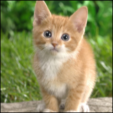
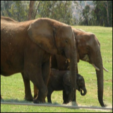
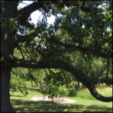
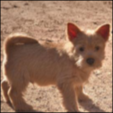

In [5]:
# Images and their labels
imgs = map(x->loadimage(imgdata[x][1], imgdata[x][2]), 1:length(imgdata));
img_crops = map(resizecropimage, imgs);
img_pres = map(preprocesscroppedimage, img_crops);
img_labels = map(x->imgdata[x][3], 1:length(imgdata));

img_crops

## Occlusion Experiments
You are going to occlude input image from different regions and observe the probability of predicted class of occluded image.

For Occlusion Experiments, you need to:
* Complete `occlude_image` method.
* Pass the generated occluded images through the model and update the results matrix with the probability of the original predicted class you get with the occluded image.

### Finishing up the occlude_image method
It is used to obtain occluded versions of the orjinal image. You are going to modify the input image by moving occlusion box through the image. You will return `occluded_images` array of arrays which stores modified images, each of which has is a `KnetArray{Float32,4}` array. The color of the occlusion box will be the mean color of original image.
Parameters of `pertubeimg` method:
* `img` : output of resizecropimage method. It's type is Array{RGB}.
* `occ_size` : `(w,h)` tuple defining the size of occlusion box.
* **Hint**: Double check that you are occluding only a single region at a time in the input image
* **Hint-2**: You may want to use **preprocesscroppedimage** method to convert your occluded image to desired type before pushing it to **occluded_images**.

In [6]:
function occlude_image(img, occ_size=(56,56))
    w,h = size(img)
    occluded_images = Any[]
    # we use these values in our occlusion box
    meanvals = mean(img)
    occbox  = zeros(RGB{Float64},(occ_size)) .+ meanvals
    for c1=1:occ_size[1]:w
        occluded_images_cols = Any[]
        for c2=1:occ_size[2]:h
            # Your code here
           
            rowMap = min(c1+occ_size[1]-1, w)
            colMap = min(c2+occ_size[2]-1, h)
            
            img_copy = deepcopy(img)
            img_copy[c1:rowMap, c2:colMap] = occbox
            
            process = preprocesscroppedimage(img_copy)

            push!(occluded_images_cols, process)
        end
        push!(occluded_images,occluded_images_cols)
    end
    occluded_images
end

occlude_image (generic function with 2 methods)

### Processing occluded_images
Inside the next cell, you will classify each occluded image stored in
`occluded_images` array. The code for classifying the original image and
iterating over the occluded images are given. After each classification, you
will store the probability of target class in the results matrix at the
correct position. `results` is an 2D array, where each point corresponds to a
occlusion region in the original image.

In [7]:
occlusion_image_index = 2

println("Most confident class and probability of the original image:")
scores = Array(resnet_forward(img_pres[occlusion_image_index]))
lindex = LinearIndices(scores)
prob, cindex = findmax(scores)
bestlabel = lindex[cindex]
println("Class $bestlabel with probability $prob\n")
flush(stdout)

occluded_images = occlude_image(img_crops[occlusion_image_index], (56,56))
# store the probability of predicted class of perturbed image.
result = zeros(length(occluded_images),length(occluded_images[1]))
println("Most confident class and probabilities of occluded images:")
for i in 1:length(occluded_images)
    for j in 1:length(occluded_images[i])
        occluded_image = occluded_images[i][j]
        # Your code here
        occ_scores_img = resnet_forward(occluded_image)
        lindex         = LinearIndices(occ_scores_img)
        prob, cindex   = findmax(occ_scores_img)
        label          = lindex[cindex]        
        result[i,j]    = prob
        println(" Occlusion ($i,$j) - Class $label with probability $prob")
    end
end
println("")
flush(stdout)

println("Probability matrix of the class under different occlusions:")
flush(stdout)
display(result)
flush(stdout)

Most confident class and probability of the original image:
Class 387 with probability 0.70209986

Most confident class and probabilities of occluded images:
 Occlusion (1,1) - Class 387 with probability 0.6363159
 Occlusion (1,2) - Class 387 with probability 0.41447857
 Occlusion (1,3) - Class 386 with probability 0.45953998
 Occlusion (1,4) - Class 387 with probability 0.6935525
 Occlusion (2,1) - Class 387 with probability 0.63051647
 Occlusion (2,2) - Class 386 with probability 0.46157226
 Occlusion (2,3) - Class 387 with probability 0.69790065
 Occlusion (2,4) - Class 387 with probability 0.8766361
 Occlusion (3,1) - Class 387 with probability 0.636001
 Occlusion (3,2) - Class 387 with probability 0.6188185
 Occlusion (3,3) - Class 387 with probability 0.7619707
 Occlusion (3,4) - Class 387 with probability 0.8565231
 Occlusion (4,1) - Class 387 with probability 0.59503394
 Occlusion (4,2) - Class 387 with probability 0.74779093
 Occlusion (4,3) - Class 387 with probability 0.5873

4×4 Array{Float64,2}:
 0.636316  0.414479  0.45954   0.693552
 0.630516  0.461572  0.697901  0.876636
 0.636001  0.618819  0.761971  0.856523
 0.595034  0.747791  0.587318  0.690971

## Saliency Maps

We will compute saliency maps described in section 3.1 of [1].

A saliency map is a guide to see which parts of the image affects the
prediction of a class. To do that you need to implement `compute_saliency`
which will return the unnormalized class score of the given image.
After implementing forward calculation AutoGrad will calculate gradients with
respect to the image pixels and the provided function will display the
saliency map.

[1] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside
Convolutional Networks: Visualising Image Classification Models and Saliency
Maps", ICLR Workshop 2014.

In [8]:
# Computes the forward calculations of saliency
#   Takes input image `image` and ground truth label `gold_label`
#   Predicts saliency map for the given image/label pair.
function compute_saliency(image, gold_label)
    # Your code here
   
    img_score = resnet_forward(image) # Returns class probabilities for the input `x`
    result    = img_score[gold_label]
    return result
end

compute_saliency (generic function with 1 method)

In [9]:
# Saliency Visualisation - for each pixel maximum of absolute gradient in each channel
mnistview(x,i)=colorview(Gray,permutedims(x[:,:,1,i],(2,1)))
function visualize_saliency(gimg1)
    g1 = abs.(gimg1);
    g2 = maximum(Array(g1), dims=3)
    g2[g2 .> 1.1f-3] .+= 0.1 ## Enhances visibility
    display(mnistview(g2,1))
end

visualize_saliency (generic function with 1 method)

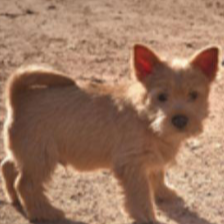

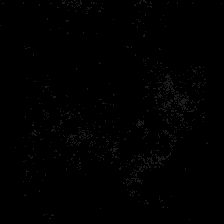

In [10]:
saliency_image_index = 4
img_param = Param(img_pres[saliency_image_index])
J = @diff compute_saliency(img_param, img_labels[saliency_image_index])
display(img_crops[saliency_image_index])
visualize_saliency(grad(J, img_param))

## Weight Visualization
We will visualize the weights of ResNet50 model's first layer.
To do that, the only thing you need to to is complete `weightvis` method.
Since you will be using an unfamiliar implementation, the weights for the
first layer of the model is already extracted from the model. Parameters
of the weightvis:
* `w`: Weight arrays.
* `scale`: resizing scale used while visualizing weights. For example, if the `scale` is (4,4) then, in the resulting image each 4x4 pixel area represents one weight.

**Hint**: You need to shift all the weight values between 0 and 1.<br>
**Hint-2**: You may want to look at `RGB` type and `colorview` method defined in `Images` package.<br>
**Hint-3**: To resize the image, you may want to take a look at `imresize` method defined in `Images` package.

In [11]:
function weightvis(model, scale=(4,4))
    # 1) Convert your weight to Array{Float32} type
    # 2) Clamp the weight array elements: All of them must be greater than or
    #    equal to zero.
    # 3) If you have N^2 filters in that layer, you will display them in a NxN
    #    grid. You will store each filter in a result array.
    # 4) You will resize each filter by using scale parameter. You may want to
    #    use imresize method.
    IJulia.clear_output(true)
    result = Any[]

    weights = model.layers[1][1].weight.value
    sqrtsize = Int(floor(sqrt(size(weights,4))))

    for i=1:sqrtsize
        result_col = Any[]
        for j=1:sqrtsize
            # Your code here
          
            convert_weight = convert(Array{Float32}, weights)

            img_array_1 = convert_weight[:,:,1,j]
            img_array_2 = convert_weight[:,:,2,j]
            img_array_3 = convert_weight[:,:,3,j]

            img = cat(img_array_1, img_array_2, img_array_3; dims= 3) 

            resize_img = imresize(img, sqrtsize, sqrtsize)
            result_col = colorview(RGB, reshape(resize_img, 3 , sqrtsize, sqrtsize))
        end
        push!(result, hcat(result_col...))
    end
    display(vcat(result...))
end

weightvis (generic function with 2 methods)

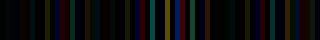

In [12]:
weightvis(model)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*